# Module 9 Assignment 1: Natural Language Processing with Disaster Tweets

**Reed Ballesteros**

**MSDS-422**

**5/29/2022**

**Instructor: Prof. Noah Gift**

## Natural Language Processing with Disaster Tweets
https://www.kaggle.com/competitions/nlp-getting-started/overview

### Background Materials
Natural language processing is an obvious area for the use of RNN, as the sequence is more important than the individual words.

### Management/Research Question
In layman’s terms, what is the management/research question of interest, and why would anyone care?  

### Requirements
- Conduct your analysis using a cross-validation design.
- Conduct EDA.
- Build at least three RNN models based on hyperparameter tuning.
- Evaluate goodness of fit metrics.
- Once you have your best-performing models, classify the test data and submit it to Kaggle. Provide your Kaggle.com user name - and screen snapshots of your scores.
- Discuss your model’s performance.

## Python Programming
All programming will be done in Python.

**Libraries to be loaded:**

In [39]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D,
                          Input)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras import Input

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

import transformers
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from transformers import TFBertModel

In [2]:
import torch
from tensorflow.python.client import device_lib
from tensorflow.config import list_physical_devices
from torch import cuda
import random

## INGEST

**Given the kind of ML involved let's see if our GPU is available for use.**

In [3]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9465245994688200864
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5769199616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12722078767901924359
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
train_df = pd.read_csv("train.csv", encoding="latin-1")
test_df = pd.read_csv("test.csv", encoding="latin-1")

train_df = train_df.dropna(how="any", axis=1)

In [6]:
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## EDA

In [8]:
balance_counts = train_df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271], dtype=int64)

Text(0.5, 1.0, 'Tweet Dataset distribution by target')

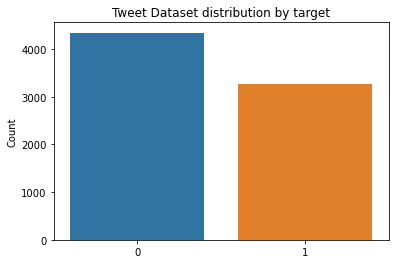

In [9]:
x_plt=train_df.target.value_counts()
sns.barplot(x=x_plt.index,y=x_plt)
plt.gca().set_ylabel('Count')
plt.gca().set_title('Tweet Dataset distribution by target')

## MODELLING

### Data Preparation/Cleaning: GLoVe-LSTM

In [10]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# https://www.kaggle.com/tanulsingh077
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")        

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

In [11]:
test_df['text_clean'] = test_df['text'].apply(preprocess_data)

train_df['text_clean'] = train_df['text'].apply(preprocess_data)
train_df.head()

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [12]:
train_tweets = train_df['text_clean'].values
test_tweets = test_df['text_clean'].values
train_target = train_df['target'].values

In [13]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13704

In [14]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)

test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3635,  467,  201, ...,    0,    0,    0],
       [ 136,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1807, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2637, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]])

In [15]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

### Model: GLoVe-LSTM

In [16]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt', encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [17]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [18]:
# https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1370400   
                                                                 
 bidirectional (Bidirectiona  (None, 23, 46)           22816     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 46)               0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 46)               184       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 46)                0         
                                                        

In [19]:
model_glove_lstm_filename = 'model_glove_lstm.h5'

In [20]:
model_glove_lstm = glove_lstm()

checkpoint = ModelCheckpoint(
    model_glove_lstm_filename, 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,
    min_lr = 0.001
)

history_glove_lstm = model_glove_lstm.fit(
    X_train, 
    y_train, 
    epochs = 10,
    batch_size = 32,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.8012 - accuracy: 0.5493
Epoch 1: val_loss improved from inf to 0.67112, saving model to model_glove_lstm.h5
179/179 [==============================] - 84s 435ms/step - loss: 0.8012 - accuracy: 0.5493 - val_loss: 0.6711 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.6484
Epoch 2: val_loss improved from 0.67112 to 0.59474, saving model to model_glove_lstm.h5
179/179 [==============================] - 85s 474ms/step - loss: 0.6498 - accuracy: 0.6484 - val_loss: 0.5947 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.7033
Epoch 3: val_loss improved from 0.59474 to 0.49720, saving model to model_glove_lstm.h5
179/179 [==============================] - 93s 521ms/step - loss: 0.5842 - accuracy: 0.7033 - val_loss: 0.4972 - val_accuracy: 0.7899 - lr: 0.0010
Epoch 4/10


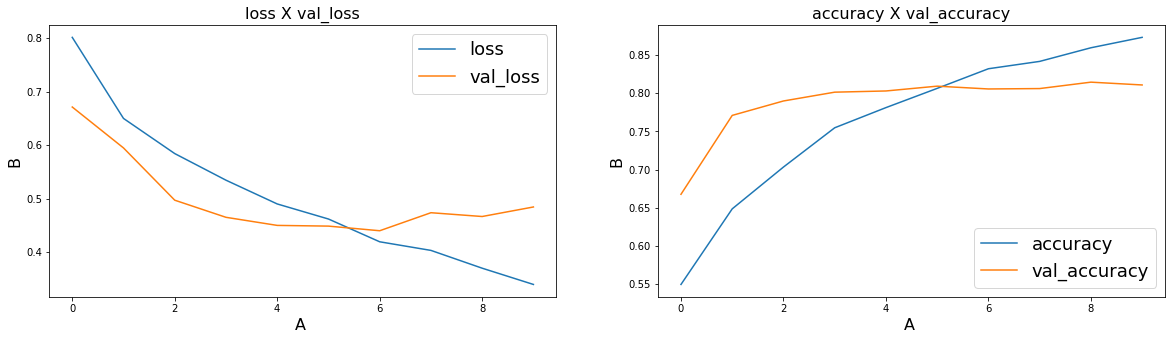

In [22]:
plot_learning_curves(history_glove_lstm, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [23]:
model_glove_lstm_final = load_model(model_glove_lstm_filename)
model_glove_lstm_final.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 100)           1370400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 23, 46)           22816     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 46)               0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_1 (Batc  (None, 46)               184       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 46)                0         
                                                      

In [24]:
y_pred_glove_lstm = (model_glove_lstm_final.predict(X_val) > 0.5).astype("int32")

60/60 [==============================] - 3s 45ms/step


In [25]:
cm = confusion_matrix(y_val,y_pred_glove_lstm)
print('confusion matrix:\n',cm)
print(classification_report(y_val, y_pred_glove_lstm))

confusion matrix:
 [[1030   70]
 [ 300  504]]
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1100
           1       0.88      0.63      0.73       804

    accuracy                           0.81      1904
   macro avg       0.83      0.78      0.79      1904
weighted avg       0.82      0.81      0.80      1904



### Submission: GLoVe-LSTM

In [26]:
y_glove_lstm = (model_glove_lstm_final.predict(test_padded_sentences) > 0.5).astype("int32")

102/102 [==============================] - 4s 44ms/step


In [28]:
y_labels = []
for i in range (0, len(y_glove_lstm)):
    y_labels.append(y_glove_lstm[i][0])

In [29]:
# create submission file
submission_glove_lstm = pd.DataFrame({"id": (test_df['id']),"target": y_labels})
submission_glove_lstm.to_csv('submission_glove_lstm.csv', index=False)

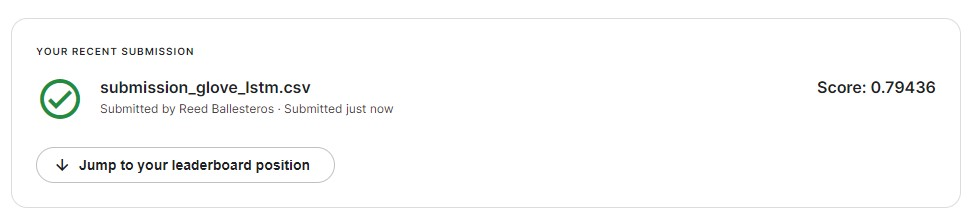

### Model: BERT

In [47]:
train_bert = pd.read_csv("train.csv")
test_bert = pd.read_csv("test.csv")

In [48]:
BERT_MODEL_NAME = 'bert-base-uncased'

In [49]:
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, do_lower_case=True)

def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []

    for i in range(len(data.text)):
        encoded = bert_tokenizer.encode_plus(
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [50]:
train_input_ids,train_attention_masks = bert_encode(train_bert,60)
test_input_ids,test_attention_masks = bert_encode(test_bert,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Reed\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [51]:
def create_model(bert_model):
    input_ids = Input(shape=(60,),dtype='int32')
    attention_masks = Input(shape=(60,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = Dense(32,activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(1,activation='sigmoid')(output)
    model = Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [52]:
bert_model_pretrained = TFBertModel.from_pretrained(BERT_MODEL_NAME)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [53]:
model_bert = create_model(bert_model_pretrained)
model_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [55]:
history_bert = model_bert.fit(
    [train_input_ids,train_attention_masks],
    train_bert['target'],
    validation_split=0.2,
    epochs=10,
    batch_size=10,
    verbose=1)

Epoch 1/10
609/609 [==============================] - 83s 120ms/step - loss: 0.4809 - accuracy: 0.7831 - val_loss: 0.4013 - val_accuracy: 0.8207
Epoch 2/10
609/609 [==============================] - 69s 113ms/step - loss: 0.3727 - accuracy: 0.8501 - val_loss: 0.3930 - val_accuracy: 0.8372
Epoch 3/10
609/609 [==============================] - 69s 113ms/step - loss: 0.3218 - accuracy: 0.8770 - val_loss: 0.3755 - val_accuracy: 0.8378
Epoch 4/10
609/609 [==============================] - 69s 113ms/step - loss: 0.2633 - accuracy: 0.9048 - val_loss: 0.4217 - val_accuracy: 0.8372
Epoch 5/10
609/609 [==============================] - 69s 113ms/step - loss: 0.2130 - accuracy: 0.9309 - val_loss: 0.4912 - val_accuracy: 0.8280
Epoch 6/10
609/609 [==============================] - 69s 113ms/step - loss: 0.1684 - accuracy: 0.9414 - val_loss: 0.6260 - val_accuracy: 0.8089
Epoch 7/10
609/609 [==============================] - 69s 113ms/step - loss: 0.1361 - accuracy: 0.9560 - val_loss: 0.6154 - val_ac

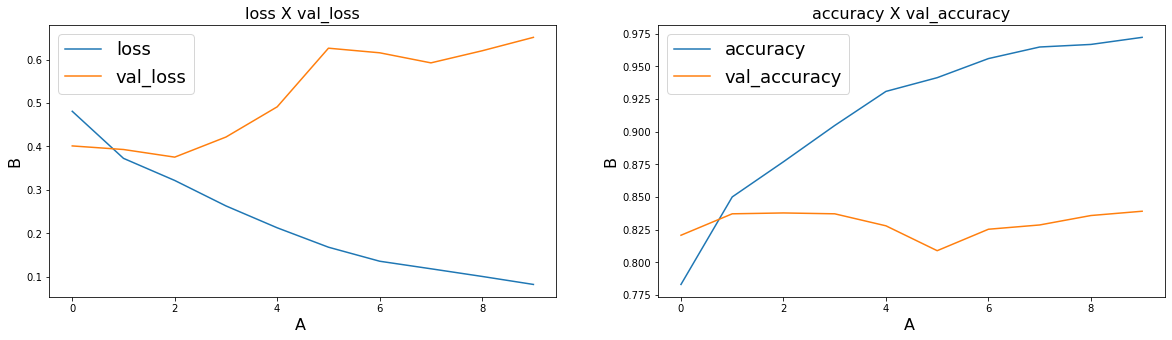

In [56]:
plot_learning_curves(history_bert, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

### Submission: BERT

In [57]:
y_bert = model_bert.predict([test_input_ids,test_attention_masks])

submission_bert = pd.read_csv('sample_submission.csv')
submission_bert['target'] = np.round(y_bert).astype(int)
submission_bert.to_csv('submission_bert.csv',index=False)
submission_bert.head()

102/102 [==============================] - 11s 82ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


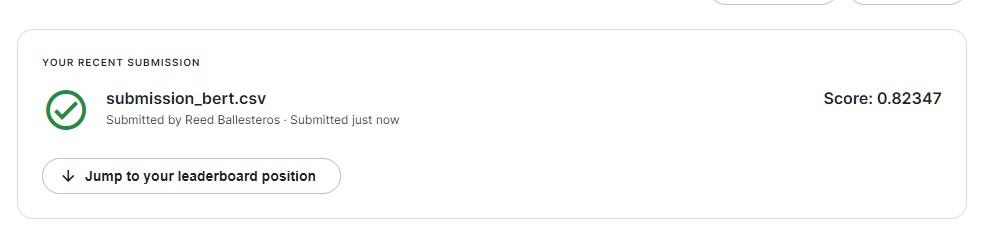

## CONCLUSION

The base BERT model performed about 2% better than the GLoVe 100D model using the Kaggle test dataset. I would like to see how much improvement there would be if I used the large BERT and GLoVe 300D models but I am limited by my local machine capabilities and hardware.